In [1]:
# Require libraries
import matplotlib.pyplot as plt
import os
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import numpy as np
import glob
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import savgol_filter
from tsmoothie.smoother import LowessSmoother


In [2]:
# Function for pixel to degree conversion

# for stimulus
def px_deg_sti(data):
    time_sti = []
    pos_sti = []
    for y in data[1]:
        new_y = round((y - 960)/49.6,4) # horizontal center:960x540 pixel : 1 deg = 49.6 pixel
        pos_sti.append(new_y)

    for x in range(1,len(pos_sti)+1):
        new_x = round((1/60)*x,4) # for monitor with screen refresh rate( 60 Hz)
        time_sti.append(new_x)
    return time_sti,pos_sti
    
# for eye
def px_deg_eye(data,dominant_eye):
    time_eye = []
    pos_eye = []
    if dominant_eye == 'right':
        for y in data['GazePointRightX (ADCSpx)']:
            new_y = round((y - 960)/49.6,4) # horizontal center:960x540 pixel : 1 deg = 49.6 pixel
            pos_eye.append(new_y)
    elif dominant_eye == 'left':
        for y in data['GazePointLeftX (ADCSpx)']:
            new_y = round((y - 960)/49.6,4) # horizontal center:960x540 pixel : 1 deg = 49.6 pixel
            pos_eye.append(new_y)
    for x in range(1,len(pos_eye)+1):
        new_x = round((1/300)*x,4) # for tobii's eye tracker with 300 Hz sampling rate
        time_eye.append(new_x)
    return time_eye,pos_eye

In [3]:
# Create path for healthy control(HC)
path = os.getcwd()
dirname = os.path.dirname(path)
option = ['URLStart','URLEnd'] # This is the values in the Studio event column where stimuli start and end events from dataset
directory_hc  = dirname+"/data/subjects/HC"
s_path = dirname+"/result/4_dps/s_hc" # single gasf path for hc
c_path = dirname+"/result/4_dps/c_hc" # combine gasf path for pd
files_hc = glob.iglob(directory_hc+'/[!.]*') # skip unwanted file such as .DS_Store file

In [4]:
# Remove outlier
def outlier_remove(df,eye):
    #data = df[eye].interpolate()
    data = df[eye]
    data = data.dropna()
    data = data.values.reshape(1,-1)
    smoother = LowessSmoother(smooth_fraction=0.1, iterations=1)
    smoother.smooth(data)
    low, up = smoother.get_intervals('prediction_interval')
    points = smoother.data[0]
    up_points = up[0]
    low_points = low[0]
    outlier = []
    for i in range(len(points)-1, 0, -1):
        current_point = points[i]
        current_up = up_points[i]
        current_low = low_points[i]
        if current_point > current_up or current_point < current_low:
            outlier.append(current_point)
    return outlier

In [5]:
# Blink detection and interpolation
def blink_nan(series,i):
    df = pd.DataFrame(series)
    df['new'] = ((df[i].notnull() != df[i].shift().notnull()).cumsum())
    df['ones'] =1
    mask_zeros = (df.groupby('new')['ones'].transform('count') == 23) | df[i].notnull()
    blink_series = series.fillna(0).where(mask_zeros)
    interpolate_series = pd.Series(blink_series).interpolate()
    return interpolate_series

In [26]:
directory_sti  = dirname+"/data/stimulus"
files_sti = glob.iglob(directory_sti+'/[!.]*')
for file_sti in files_sti: 
    # for stimulus (speed = 4deg/s, duration = 23 sec)
    data_sti = pd.read_csv(file_sti,sep='\s+',header=None)
    one_deg_time_sti , one_deg_pos_sti =  px_deg_sti(data_sti)
    stimulus = pd.DataFrame({'x':one_deg_time_sti,'y':one_deg_pos_sti})
    stimulus.to_csv(str(Path(file_sti).stem)+'_sti.csv',index=False)

In [ ]:
# Four degree
def csv(speed):
    frames = []
    for file_hc in files_hc:  
        # Data preporcessing
        # Interpolate the NaN values with linear
        data_hc  = pd.read_excel(file_hc+'/'+speed)#.interpolate()
        t = data_hc[data_hc['StudioEvent'].isin(option)].index # Caculating start and end of stimuli
        
        # First Trial
        data_eye_hc_first = data_hc[t[0]+902:t[0]+7804] # first trial index
        outlier_first  = outlier_remove(data_eye_hc_first['GazePointRightX (ADCSpx)'])
        for i in outlier_first: data_eye_hc_first.drop(data_eye_hc_first.index[data_eye_hc_first['GazePointRightX (ADCSpx)'] == i],inplace=True)
        data_eye_hc_first  =  blink_nan(data_eye_hc_first['GazePointRightX (ADCSpx)'],'GazePointRightX (ADCSpx)')
        data_eye_hc_first  = data_eye_hc_first.dropna()
        data_eye_hc_first  = data_eye_hc_first.to_frame()
        one_deg_time_eye , one_deg_pos_eye =  px_deg_eye(data_eye_hc_first,'right')
        one_deg_first = pd.DataFrame({'x1_'+str(os.path.basename(file_hc)):one_deg_time_eye,
        'y1_'+str(os.path.basename(file_hc)):one_deg_pos_eye})


        # Second Trial
        data_eye_hc_second = data_hc[t[2]+902:t[2]+7804]
        outlier_second = outlier_remove(data_eye_hc_second['GazePointRightX (ADCSpx)'])
        for i in outlier_second: data_eye_hc_second.drop(data_eye_hc_second.index[data_eye_hc_second['GazePointRightX (ADCSpx)'] == i],inplace=True)
        data_eye_hc_second  =  blink_nan(data_eye_hc_second['GazePointRightX (ADCSpx)'],'GazePointRightX (ADCSpx)')
        data_eye_hc_second  = data_eye_hc_first.dropna()
        data_eye_hc_first  = data_eye_hc_first.to_frame()
        one_deg_time_eye_second , one_deg_pos_eye_second =  px_deg_eye(data_eye_hc_second,'right')
        one_deg_second = pd.DataFrame({'x2_'+str(os.path.basename(file_hc)):one_deg_time_eye_second,
        'y2_'+str(os.path.basename(file_hc)):one_deg_pos_eye_second})

        df_subject = pd.concat([one_deg_first,one_deg_second],axis=1)

        frames.append(df_subject)

    one_deg = pd.concat(frames,axis=1)
   
    one_deg.to_csv('one_deg.csv',index=False)

In [17]:
# for one degree
def csv(speed):
    frames = []
    for file_hc in files_hc:  
        # Data preporcessing
        # Interpolate the NaN values with linear
        data_hc  = pd.read_excel(file_hc+'/'+speed)#.interpolate()
        t = data_hc[data_hc['StudioEvent'].isin(option)].index # Caculating start and end of stimuli
        data_eye_hc_first = data_hc[t[0]+902:t[0]+27904] # first trial index
        data_eye_hc_second = data_hc[t[2]+902:t[2]+27904] # second trail index

        data_eye_hc_first['GazePointRightX (ADCSpx)']  = remove_outlier_IQR(data_eye_hc_first['GazePointRightX (ADCSpx)'])
        data_eye_hc_first  = data_eye_hc_first.interpolate()

        data_eye_hc_second['GazePointRightX (ADCSpx)'] = remove_outlier_IQR(data_eye_hc_second['GazePointRightX (ADCSpx)'])
        data_eye_hc_second  = data_eye_hc_second.interpolate()

        # First trial
        one_deg_time_eye , one_deg_pos_eye =  px_deg_eye(data_eye_hc_first,'right')

        # Second trial
        one_deg_time_eye_second , one_deg_pos_eye_second =  px_deg_eye(data_eye_hc_second,'right')

        one_deg_first = pd.DataFrame({'x1_'+str(os.path.basename(file_hc)):one_deg_time_eye,
        'y1_'+str(os.path.basename(file_hc)):one_deg_pos_eye})

        one_deg_second = pd.DataFrame({'x2_'+str(os.path.basename(file_hc)):one_deg_time_eye_second,
        'y2_'+str(os.path.basename(file_hc)):one_deg_pos_eye_second})

     

        df_subject = pd.concat([one_deg_first,one_deg_second],axis=1)

        frames.append(df_subject)

    one_deg = pd.concat(frames,axis=1)
   
    one_deg.to_csv('one_deg.csv',index=False)
    



In [27]:
# For two degree
def csv(speed):
    frames = []
    for file_hc in files_hc:  
        # Data preporcessing
        # Interpolate the NaN values with linear
        data_hc  = pd.read_excel(file_hc+'/'+speed)#.interpolate()
        t = data_hc[data_hc['StudioEvent'].isin(option)].index # Caculating start and end of stimuli
        data_eye_hc_first = data_hc[t[0]+902:t[0]+14404] # first trial index
        data_eye_hc_second = data_hc[t[2]+902:t[2]+14404]

        data_eye_hc_first['GazePointRightX (ADCSpx)']  = remove_outlier_IQR(data_eye_hc_first['GazePointRightX (ADCSpx)'])
        data_eye_hc_first  = data_eye_hc_first.interpolate()

        data_eye_hc_second['GazePointRightX (ADCSpx)'] = remove_outlier_IQR(data_eye_hc_second['GazePointRightX (ADCSpx)'])
        data_eye_hc_second  = data_eye_hc_second.interpolate()

        # First trial
        one_deg_time_eye , one_deg_pos_eye =  px_deg_eye(data_eye_hc_first,'right')

        # Second trial
        one_deg_time_eye_second , one_deg_pos_eye_second =  px_deg_eye(data_eye_hc_second,'right')

        one_deg_first = pd.DataFrame({'x1_'+str(os.path.basename(file_hc)):one_deg_time_eye,
        'y1_'+str(os.path.basename(file_hc)):one_deg_pos_eye})

        one_deg_second = pd.DataFrame({'x2_'+str(os.path.basename(file_hc)):one_deg_time_eye_second,
        'y2_'+str(os.path.basename(file_hc)):one_deg_pos_eye_second})

     

        df_subject = pd.concat([one_deg_first,one_deg_second],axis=1)

        frames.append(df_subject)

    one_deg = pd.concat(frames,axis=1)
   
    one_deg.to_csv('two_deg.csv',index=False)

In [36]:
# For six degree
def csv(speed):
    frames = []
    for file_hc in files_hc:  
        # Data preporcessing
        # Interpolate the NaN values with linear
        data_hc  = pd.read_excel(file_hc+'/'+speed)#.interpolate()
        t = data_hc[data_hc['StudioEvent'].isin(option)].index # Caculating start and end of stimuli
        data_eye_hc_first = data_hc[t[0]+902:t[0]+5404] # first trial index
        data_eye_hc_second = data_hc[t[2]+902:t[2]+5404] # second trail index

        data_eye_hc_first['GazePointRightX (ADCSpx)']  = remove_outlier_IQR(data_eye_hc_first['GazePointRightX (ADCSpx)'])
        data_eye_hc_first  = data_eye_hc_first.interpolate()

        data_eye_hc_second['GazePointRightX (ADCSpx)'] = remove_outlier_IQR(data_eye_hc_second['GazePointRightX (ADCSpx)'])
        data_eye_hc_second  = data_eye_hc_second.interpolate()

        # First trial
        one_deg_time_eye , one_deg_pos_eye =  px_deg_eye(data_eye_hc_first,'right')

        # Second trial
        one_deg_time_eye_second , one_deg_pos_eye_second =  px_deg_eye(data_eye_hc_second,'right')

        one_deg_first = pd.DataFrame({'x1_'+str(os.path.basename(file_hc)):one_deg_time_eye,
        'y1_'+str(os.path.basename(file_hc)):one_deg_pos_eye})

        one_deg_second = pd.DataFrame({'x2_'+str(os.path.basename(file_hc)):one_deg_time_eye_second,
        'y2_'+str(os.path.basename(file_hc)):one_deg_pos_eye_second})

     

        df_subject = pd.concat([one_deg_first,one_deg_second],axis=1)

        frames.append(df_subject)

    one_deg = pd.concat(frames,axis=1)
   
    one_deg.to_csv('six_deg.csv',index=False)

In [44]:
# For eight degree
def csv(speed):
    frames = []
    for file_hc in files_hc:  
        # Data preporcessing
        # Interpolate the NaN values with linear
        data_hc  = pd.read_excel(file_hc+'/'+speed)#.interpolate()
        t = data_hc[data_hc['StudioEvent'].isin(option)].index # Caculating start and end of stimuli
        data_eye_hc_first = data_hc[t[0]+902:t[0]+4204] # first trial index
        data_eye_hc_second = data_hc[t[2]+902:t[2]+4204] # second trail index

        data_eye_hc_first['GazePointRightX (ADCSpx)']  = remove_outlier_IQR(data_eye_hc_first['GazePointRightX (ADCSpx)'])
        data_eye_hc_first  = data_eye_hc_first.interpolate()

        data_eye_hc_second['GazePointRightX (ADCSpx)'] = remove_outlier_IQR(data_eye_hc_second['GazePointRightX (ADCSpx)'])
        data_eye_hc_second  = data_eye_hc_second.interpolate()

        # First trial
        one_deg_time_eye , one_deg_pos_eye =  px_deg_eye(data_eye_hc_first,'right')

        # Second trial
        one_deg_time_eye_second , one_deg_pos_eye_second =  px_deg_eye(data_eye_hc_second,'right')

        one_deg_first = pd.DataFrame({'x1_'+str(os.path.basename(file_hc)):one_deg_time_eye,
        'y1_'+str(os.path.basename(file_hc)):one_deg_pos_eye})

        one_deg_second = pd.DataFrame({'x2_'+str(os.path.basename(file_hc)):one_deg_time_eye_second,
        'y2_'+str(os.path.basename(file_hc)):one_deg_pos_eye_second})

     

        df_subject = pd.concat([one_deg_first,one_deg_second],axis=1)

        frames.append(df_subject)

    one_deg = pd.concat(frames,axis=1)
   
    one_deg.to_csv('eight_deg.csv',index=False)

In [45]:
csv('8_dps.xlsx')

## For PD

In [71]:
# Create path fo pd
path = os.getcwd()
dirname = os.path.dirname(path)
option = ['URLStart','URLEnd']
directory_pd  = dirname+"/data/subjects/PD"
option = ['URLStart','URLEnd']
files_pd = glob.iglob(directory_pd+'/[!.]*') # skip unwanted file such as .DS_Store file

In [52]:
# for one degree
def csv(speed):
    frames = []
    for file_pd in files_pd:  
        # Data preporcessing
        # Interpolate the NaN values with linear
        data_pd  = pd.read_excel(file_pd+'/'+speed)#.interpolate()
        t = data_pd[data_pd['StudioEvent'].isin(option)].index # Caculating start and end of stimuli
        data_eye_pd_first = data_pd[t[0]+902:t[0]+27904] # first trial index
        data_eye_pd_second = data_pd[t[2]+902:t[2]+27904] # second trail index

        data_eye_pd_first['GazePointRightX (ADCSpx)']  = remove_outlier_IQR(data_eye_pd_first['GazePointRightX (ADCSpx)'])
        data_eye_pd_first  = data_eye_pd_first.interpolate()

        data_eye_pd_second['GazePointRightX (ADCSpx)'] = remove_outlier_IQR(data_eye_pd_second['GazePointRightX (ADCSpx)'])
        data_eye_pd_second  = data_eye_pd_second.interpolate()

        # First trial
        one_deg_time_eye , one_deg_pos_eye =  px_deg_eye(data_eye_pd_first,'right')

        # Second trial
        one_deg_time_eye_second , one_deg_pos_eye_second =  px_deg_eye(data_eye_pd_second,'right')

        one_deg_first = pd.DataFrame({'x1_'+str(os.path.basename(file_pd)):one_deg_time_eye,
        'y1_'+str(os.path.basename(file_pd)):one_deg_pos_eye})

        one_deg_second = pd.DataFrame({'x2_'+str(os.path.basename(file_pd)):one_deg_time_eye_second,
        'y2_'+str(os.path.basename(file_pd)):one_deg_pos_eye_second})

     

        df_subject = pd.concat([one_deg_first,one_deg_second],axis=1)

        frames.append(df_subject)

    one_deg = pd.concat(frames,axis=1)
   
    one_deg.to_csv('one_deg.csv',index=False)
    



In [55]:
# for two degree
def csv(speed):
    frames = []
    for file_pd in files_pd:  
        # Data preporcessing
        # Interpolate the NaN values with linear
        data_pd  = pd.read_excel(file_pd+'/'+speed)#.interpolate()
        t = data_pd[data_pd['StudioEvent'].isin(option)].index # Caculating start and end of stimuli
        data_eye_pd_first = data_pd[t[0]+902:t[0]+14404] # first trial index
        data_eye_pd_second = data_pd[t[2]+902:t[2]+14404] # second trail index

        data_eye_pd_first['GazePointRightX (ADCSpx)']  = remove_outlier_IQR(data_eye_pd_first['GazePointRightX (ADCSpx)'])
        data_eye_pd_first  = data_eye_pd_first.interpolate()

        data_eye_pd_second['GazePointRightX (ADCSpx)'] = remove_outlier_IQR(data_eye_pd_second['GazePointRightX (ADCSpx)'])
        data_eye_pd_second  = data_eye_pd_second.interpolate()

        # First trial
        one_deg_time_eye , one_deg_pos_eye =  px_deg_eye(data_eye_pd_first,'right')

        # Second trial
        one_deg_time_eye_second , one_deg_pos_eye_second =  px_deg_eye(data_eye_pd_second,'right')

        one_deg_first = pd.DataFrame({'x1_'+str(os.path.basename(file_pd)):one_deg_time_eye,
        'y1_'+str(os.path.basename(file_pd)):one_deg_pos_eye})

        one_deg_second = pd.DataFrame({'x2_'+str(os.path.basename(file_pd)):one_deg_time_eye_second,
        'y2_'+str(os.path.basename(file_pd)):one_deg_pos_eye_second})

     

        df_subject = pd.concat([one_deg_first,one_deg_second],axis=1)

        frames.append(df_subject)

    one_deg = pd.concat(frames,axis=1)
   
    one_deg.to_csv('two_deg.csv',index=False)
    



In [64]:
# for Four degree
def csv(speed):
    frames = []
    for file_pd in files_pd:  
        # Data preporcessing
        # Interpolate the NaN values with linear
        data_pd  = pd.read_excel(file_pd+'/'+speed)#.interpolate()
        t = data_pd[data_pd['StudioEvent'].isin(option)].index # Caculating start and end of stimuli
        data_eye_pd_first = data_pd[t[0]+902:t[0]+7804] # first trial index
        data_eye_pd_second = data_pd[t[2]+902:t[2]+7804] # second trail index

        data_eye_pd_first['GazePointRightX (ADCSpx)']  = remove_outlier_IQR(data_eye_pd_first['GazePointRightX (ADCSpx)'])
        data_eye_pd_first  = data_eye_pd_first.interpolate()

        data_eye_pd_second['GazePointRightX (ADCSpx)'] = remove_outlier_IQR(data_eye_pd_second['GazePointRightX (ADCSpx)'])
        data_eye_pd_second  = data_eye_pd_second.interpolate()

        # First trial
        one_deg_time_eye , one_deg_pos_eye =  px_deg_eye(data_eye_pd_first,'right')

        # Second trial
        one_deg_time_eye_second , one_deg_pos_eye_second =  px_deg_eye(data_eye_pd_second,'right')

        one_deg_first = pd.DataFrame({'x1_'+str(os.path.basename(file_pd)):one_deg_time_eye,
        'y1_'+str(os.path.basename(file_pd)):one_deg_pos_eye})

        one_deg_second = pd.DataFrame({'x2_'+str(os.path.basename(file_pd)):one_deg_time_eye_second,
        'y2_'+str(os.path.basename(file_pd)):one_deg_pos_eye_second})

     

        df_subject = pd.concat([one_deg_first,one_deg_second],axis=1)

        frames.append(df_subject)

    one_deg = pd.concat(frames,axis=1)
   
    one_deg.to_csv('four_deg.csv',index=False)
    



In [68]:
# for six degree
def csv(speed):
    frames = []
    for file_pd in files_pd:  
        # Data preporcessing
        # Interpolate the NaN values with linear
        data_pd  = pd.read_excel(file_pd+'/'+speed)#.interpolate()
        t = data_pd[data_pd['StudioEvent'].isin(option)].index # Caculating start and end of stimuli
        data_eye_pd_first = data_pd[t[0]+902:t[0]+5404] # first trial index
        data_eye_pd_second = data_pd[t[2]+902:t[2]+5404] # second trail index

        data_eye_pd_first['GazePointRightX (ADCSpx)']  = remove_outlier_IQR(data_eye_pd_first['GazePointRightX (ADCSpx)'])
        data_eye_pd_first  = data_eye_pd_first.interpolate()

        data_eye_pd_second['GazePointRightX (ADCSpx)'] = remove_outlier_IQR(data_eye_pd_second['GazePointRightX (ADCSpx)'])
        data_eye_pd_second  = data_eye_pd_second.interpolate()

        # First trial
        one_deg_time_eye , one_deg_pos_eye =  px_deg_eye(data_eye_pd_first,'right')

        # Second trial
        one_deg_time_eye_second , one_deg_pos_eye_second =  px_deg_eye(data_eye_pd_second,'right')

        one_deg_first = pd.DataFrame({'x1_'+str(os.path.basename(file_pd)):one_deg_time_eye,
        'y1_'+str(os.path.basename(file_pd)):one_deg_pos_eye})

        one_deg_second = pd.DataFrame({'x2_'+str(os.path.basename(file_pd)):one_deg_time_eye_second,
        'y2_'+str(os.path.basename(file_pd)):one_deg_pos_eye_second})

     

        df_subject = pd.concat([one_deg_first,one_deg_second],axis=1)

        frames.append(df_subject)

    one_deg = pd.concat(frames,axis=1)
   
    one_deg.to_csv('six_deg.csv',index=False)
    



In [72]:
# for eight degree
def csv(speed):
    frames = []
    for file_pd in files_pd:  
        # Data preporcessing
        # Interpolate the NaN values with linear
        data_pd  = pd.read_excel(file_pd+'/'+speed)#.interpolate()
        t = data_pd[data_pd['StudioEvent'].isin(option)].index # Caculating start and end of stimuli
        data_eye_pd_first = data_pd[t[0]+902:t[0]+4204] # first trial index
        data_eye_pd_second = data_pd[t[2]+902:t[2]+4204] # second trail index


        data_eye_pd_first['GazePointRightX (ADCSpx)']  = remove_outlier_IQR(data_eye_pd_first['GazePointRightX (ADCSpx)'])
        data_eye_pd_first  = data_eye_pd_first.interpolate()

        data_eye_pd_second['GazePointRightX (ADCSpx)'] = remove_outlier_IQR(data_eye_pd_second['GazePointRightX (ADCSpx)'])
        data_eye_pd_second  = data_eye_pd_second.interpolate()

        # First trial
        one_deg_time_eye , one_deg_pos_eye =  px_deg_eye(data_eye_pd_first,'right')

        # Second trial
        one_deg_time_eye_second , one_deg_pos_eye_second =  px_deg_eye(data_eye_pd_second,'right')

        one_deg_first = pd.DataFrame({'x1_'+str(os.path.basename(file_pd)):one_deg_time_eye,
        'y1_'+str(os.path.basename(file_pd)):one_deg_pos_eye})

        one_deg_second = pd.DataFrame({'x2_'+str(os.path.basename(file_pd)):one_deg_time_eye_second,
        'y2_'+str(os.path.basename(file_pd)):one_deg_pos_eye_second})

     

        df_subject = pd.concat([one_deg_first,one_deg_second],axis=1)

        frames.append(df_subject)

    one_deg = pd.concat(frames,axis=1)
   
    one_deg.to_csv('eight_deg.csv',index=False)
    



In [73]:
csv('8_dps.xlsx')

<AxesSubplot:xlabel='x', ylabel='y'>

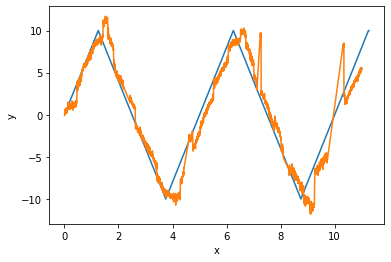

In [80]:
import seaborn as sns
x= pd.read_csv('8_deg_per_sec_sti.csv')
sns.lineplot(x='x', y='y', data=x)

y = pd.read_csv('eight_deg.csv')

sns.lineplot(x='x1_PDQE102',y='y1_PDQE102',data=y)